# **Sentiment analysis with RNNs**

In this task, you will implement LSTM architectures with PyTorch to perform a sentiment analysis for movie reviews.


## Download the required datasets

Executing this cell will download all the records needed to work on the homework

In [1]:
# Download glove
!wget https://github.com/uclnlp/inferbeddings/raw/master/data/glove/glove.6B.50d.txt.gz
!gzip -f -d glove.6B.50d.txt.gz

# install datasets from huggingface
!pip install datasets

zsh:1: command not found: wget
gzip: can't stat: glove.6B.50d.txt.gz (glove.6B.50d.txt.gz.gz): No such file or directory


## Use the GPU for computations if possible

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Library Imports

In [3]:
import torch.nn as nn
import os
import re
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from collections import defaultdict
from sklearn.metrics import f1_score
from datasets import load_dataset
from tqdm import tqdm

/Users/julian.steiner/.virtualenvs/deep-learning-for-natural-language-processing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Specify random seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set random seeds; do not change this!
seed_everything(seed=42)

## **Task 1 [6P]: Data sets and pretrained Embeddings**

In the first cell you've downloaded (!wget ...) the uncased GloVe embeddings with 6B tokens [glove.6B.zip](https://nlp.stanford.edu/projects/glove/) from Stanford. For performance reasons, we will only use the 50-dimensional embeddings **glove.6B.50d.txt**.

a) [2P] Implement a function to read the embeddings.

In [5]:
def read_embeddings(embedding_path):
    embeddings = defaultdict(list)
    with open(embedding_path, 'r') as f:
      for line in f:
        values = line.split()
        word = values[0]
        vector = np.asanyarray(values[1:], "float32")
        embeddings[word] = vector
    return embeddings

b) [2P] Implement a function, which receives a tokenized word list (e.g. a sentence) and returns the embedded word list. Don't forget to handle words without corresponding embedding. In that case you can return a randomly initialized embedding or the zero-embedding (list with 50 zeros). Use your previously defined method "read_embeddings" get the embeddings from the "glove.6B.50d.txt"-textfile.

In [49]:
embeddings_path = "glove.6B.50d.txt" # path to your embedding file
embeddings = read_embeddings(embeddings_path)

def embed_data(sentence_list):
    embedding_vectors = [embeddings[token] if token in embeddings else np.zeros((50,)) for token in sentence_list]
    return torch.tensor(embedding_vectors, dtype=torch.float32)

c) [1P] Implement a `split_string` function which tokenizes a text of multiple sentences. It should take a string as input and return a list of tokens. Each token is separated by an empty space ' '. Make sure to remove "." and "," beforehand and return all tokens in lowercase.

In [50]:
def split_string(text):
  return [token.replace('.', '').replace(',', '').lower() for token in text.split(' ')]

d) [1P] Load the IMDB-Reviews dataset "stanfordnlp/imdb" using the `load_dasetset`-function that is imported above. Shuffle the dataset with `seed=42` after loading. Use only the first `2500` entries of the training und testing-datasets!

In [51]:
dataset = load_dataset('stanfordnlp/imdb')
train_dataset = dataset['train'].shuffle(seed=42).select(range(2500))
test_dataset = dataset['test'].shuffle(seed=42).select(range(2500))


Execute the following cell to transfer the dataset to a pytorch dataloader. If the following `code breaks`, reconsider your solution of the previous task.

In [52]:
class IMDBDataset(Dataset):
    def __init__(self, dataset, device):
        self.labels = torch.tensor(dataset["label"], device=device)
        self.lengths = []
        self.data = []
        for text in tqdm(dataset["text"]):
          tokens = split_string(text)
          embeddings = embed_data(tokens)
          self.data.append(embeddings.to(device))
          self.lengths.append(len(embeddings))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embeddings = self.data[idx]
        label = self.labels[idx]
        length = self.lengths[idx]

        return embeddings, length, label

def create_dataloader(dataset, device, batch_size=1, shuffle=True):
    imdb_dataset = IMDBDataset(dataset, device)
    dataloader = DataLoader(imdb_dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [66]:
print("Create dataloader for training")
train_dataloader = create_dataloader(train_dataset, device, 1)

print("Create dataloader for testing")
test_dataloader = create_dataloader(test_dataset, device, 1)

Create dataloader for training


100%|██████████| 2500/2500 [00:02<00:00, 996.09it/s] 


Create dataloader for testing


100%|██████████| 2500/2500 [00:02<00:00, 1057.77it/s]


# **Task 2 [5P]: LSTM Model**

a) [3P] We will use PyTorch to build our LSTM. Remember that the label of a review can be 0 and 1, the model should therefore return a probability between 0 and 1 as it's final output.  
The LSTM will be **unidirectional**. The model will have the following components:
1. A [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) which takes the embeddings as input and has a 100 dimensional hidden size.
3. A linear layer with input size of 100 and output size of the number of labels
4. A [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) activation function

Note:  
You should use the method-parameters from the __init__ method to specify layer sizes. Concrete dimension numbers will be assigned in part b)


In [70]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_output_label):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, num_output_label)
        self.sig = nn.Sigmoid()

    def forward(self, input_word_embedding):
        x, _ = self.lstm(input_word_embedding)
        x = self.linear(x)
        x = self.sig(x)
        return x

b) [2P] Initialize the previously defined LSTM model.

In [71]:
lstm = LSTM(
    input_size=50,
    hidden_size=100,
    num_layers=1,
    num_output_label=1
)
lstm.to(device)


LSTM(
  (lstm): LSTM(50, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sig): Sigmoid()
)

# **Task 3 [11P]: Training an LSTM-Model**
In the following exercise you will train the LSTM model.

**Hint**: you can check out this [link](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) to get to know more about how to train a model with pytorch. Also remember the following architecture from the lecture when handling the model output and computing the loss:
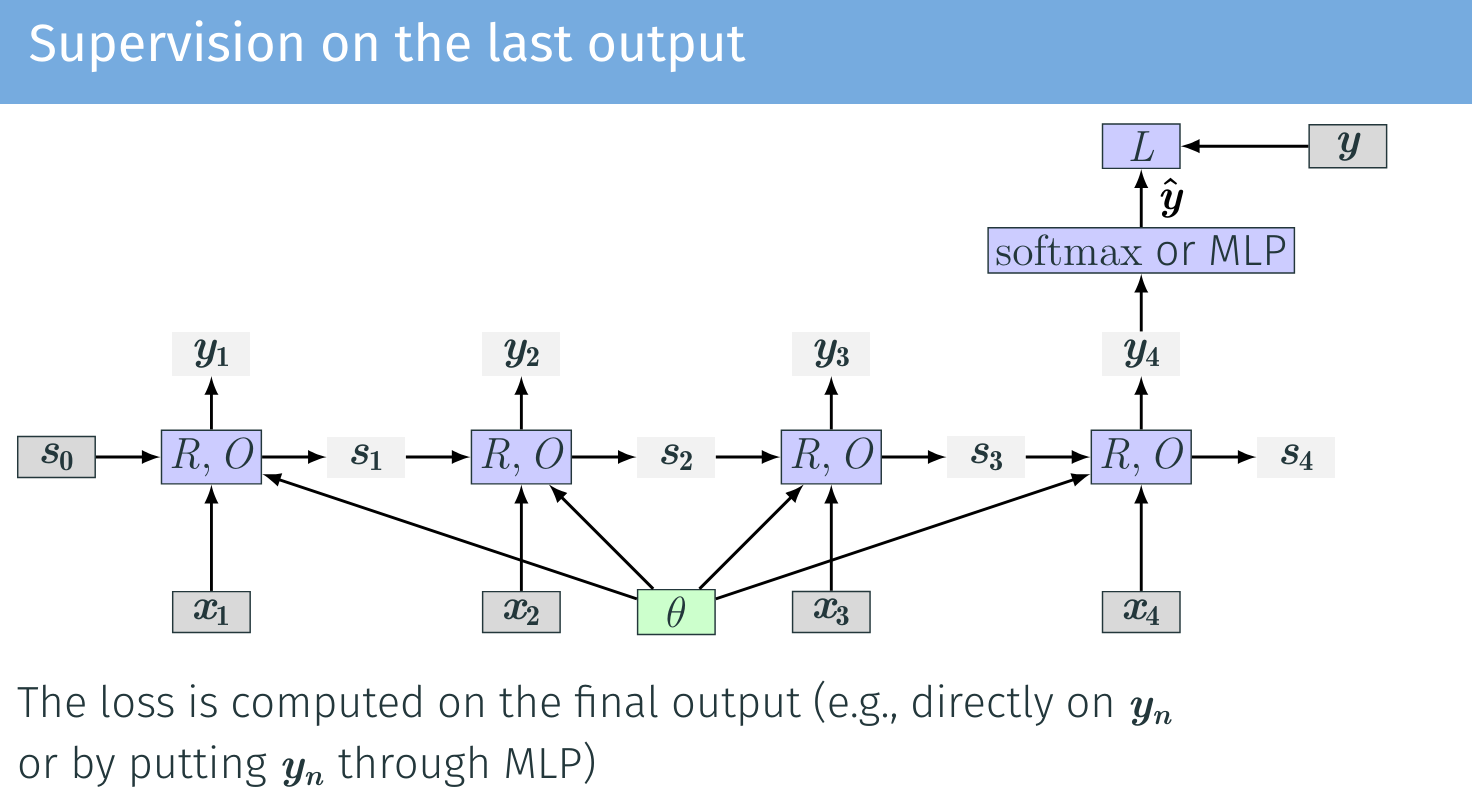



a) [1P] Initialize the loss function, optimizer and and epoch number for the upcoming training process. Use the Binary Cross Entropy loss and the Adam Optimizer with a learn rate of 0.0007 and an epoch number of 15.


In [72]:
epochs=15
lr = 0.0007

loss_func = nn.BCELoss()
optimizer = torch.optim.AdamW(
    params=lstm.parameters(),
    lr=lr
)

b) [7.5P] Complete the function `train` to train your model. The model will train with batch size of 1 (each review is a sample). You will train the model with the train dataset and use the test dataset to check the model's performance after each epoch. Calculate the macro f1 score of the model on the test dataset. Return the losses and f1 scores for plotting.

For the f1 score you can use `sklearn.metrics.f1_score`.


Make sure to use the provided `device` variable from above to ensure that pytorch uses the GPU when training the model. This will speed up the training process. In our site it took about 3 minutes for 15 epochs.

In [74]:
def train(model, num_epochs, loss_function, optimizer, train_dataloader, test_dataloader, device):
  epoch_loss_logger = []
  epoch_f1_scores = []

  model.train()
  for epoch in range(num_epochs):
      print(f"\n Epoch {epoch+1} of {num_epochs}")

      batch_loss_logger = []

      # training
      for batch_data in train_dataloader:
        input, _, target  = batch_data
        input, target = input.to(device), target.to(device)

        prediction = model(input)
        prediction = prediction[0, -1, :]

        train_loss = loss_function(prediction, target.to(torch.float))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        batch_loss_logger.append(train_loss.item())
      
      epoch_loss_logger.append(sum(batch_loss_logger) / len(batch_loss_logger))

      # evaluation
      model.eval()

      predictions = []
      targets = []

      with torch.no_grad():
         for batch_data in test_dataloader:
            input, _, target  = batch_data
            input, target = input.to(device), target.to(device)

            prediction = model(input)
            prediction = prediction[0, -1, :]

            predictions.append(prediction)
            targets.append(target)
      
      predictions = (torch.tensor(predictions) > 0.5).float()
      targets = torch.tensor(targets).float()
      epoch_f1_scores.append(f1_score(targets, predictions))

  return epoch_loss_logger, epoch_f1_scores

c) [0.5P] Use the train function to train the lstm model. Save the epoch losses and the f1 scores.

In [75]:
epoch_loss_logger, epoch_f1_scores = train(
    model=lstm,
    num_epochs=epochs,
    loss_function=loss_func,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device
)


 Epoch 1 of 15

 Epoch 2 of 15

 Epoch 3 of 15

 Epoch 4 of 15

 Epoch 5 of 15

 Epoch 6 of 15

 Epoch 7 of 15

 Epoch 8 of 15

 Epoch 9 of 15

 Epoch 10 of 15

 Epoch 11 of 15

 Epoch 12 of 15

 Epoch 13 of 15

 Epoch 14 of 15

 Epoch 15 of 15


d) [2P] Write a function visualize_data which plots a list of values. This can be done with mathplotlib.pyplot.Use this function to visualize the epoch losses and f1 scores from the previous subtask.

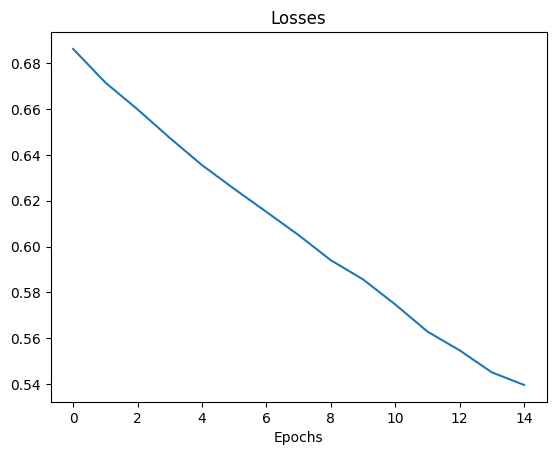

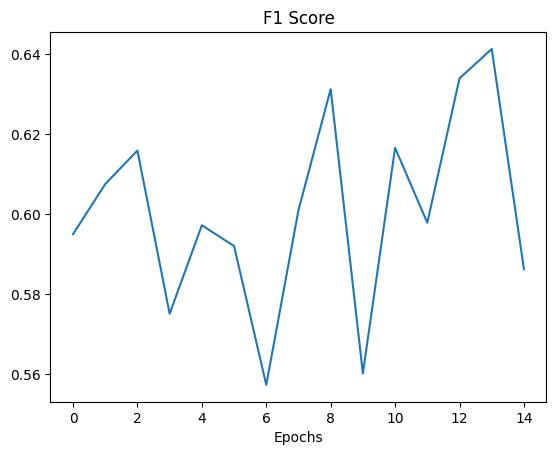

In [76]:
def visualize_data(data, title):
  plt.plot(data)
  plt.title(title)
  plt.xlabel("Epochs")
  plt.show()


visualize_data(epoch_loss_logger, "Losses")
visualize_data(epoch_f1_scores, "F1 Score")

# **Task 4 [4P]: Training an RNN-Model**

In the following task you will reuse the function that you have defined to train the LSTM (from above) to evaluate it's performance compared to an RNN architecture

Here, we provide the model defintion for you.

In [78]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_output_label):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.layers = nn.Sequential(
            nn.Linear(hidden_size, num_output_label),
            nn.Sigmoid()
        )

    def forward(self, input_word_embedding):
        rnn_output, _ = self.rnn(input_word_embedding)
        return self.layers(rnn_output)

a) [1P] Initialize the RNN-model, and prepare the loss_function and the optimizer for training. Here you should also use BCELoss and the Adam-Optimizer with a learning rate of 0.0007. We are training for 15 episodes here as well.

Use the same parameters as before.

In [79]:
rnn = RNN(
    input_size=50,
    hidden_size=100,
    num_layers=1,
    num_output_label=1
)
rnn.to(device)

optimizer = torch.optim.AdamW(rnn.parameters(), lr=lr)
loss_func = nn.BCELoss()

b) [0.5P] Reuse the train-function from above to train the RNN and capture the loss and f1-score

In [80]:
epoch_loss_logger, epoch_f1_scores = train(
    model=rnn,
    num_epochs=epochs,
    loss_function=loss_func,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device
)


 Epoch 1 of 15

 Epoch 2 of 15

 Epoch 3 of 15

 Epoch 4 of 15

 Epoch 5 of 15

 Epoch 6 of 15

 Epoch 7 of 15

 Epoch 8 of 15

 Epoch 9 of 15

 Epoch 10 of 15

 Epoch 11 of 15

 Epoch 12 of 15

 Epoch 13 of 15

 Epoch 14 of 15

 Epoch 15 of 15


c) [0.5P] For the RNN-model you should also visiualize the F1-score and the loss. You can reuse the code from above.

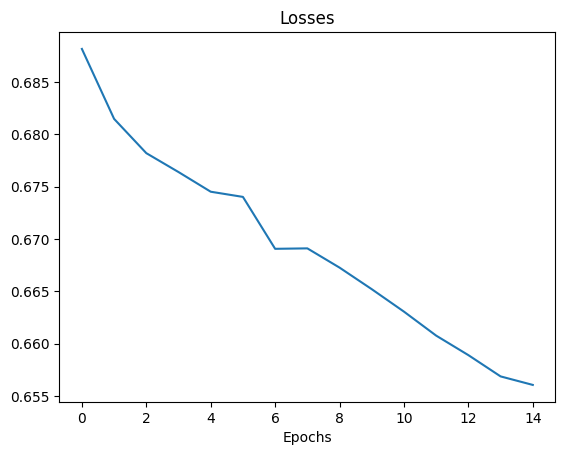

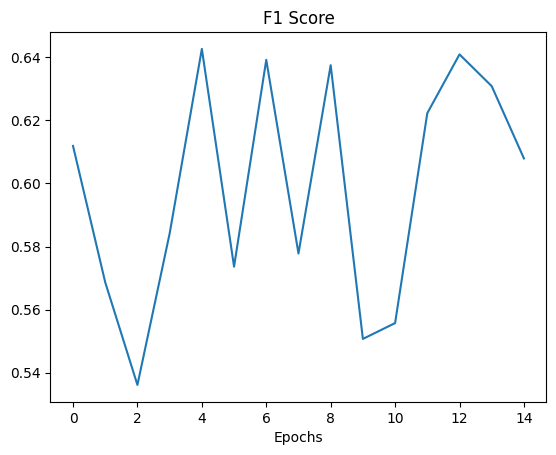

In [81]:
visualize_data(epoch_loss_logger, "Losses")
visualize_data(epoch_f1_scores, "F1 Score")

d) [2P] Compare the training process of the RNN-Model to the LSTM-Model, what do you recognize and how can you explain these effects?

In [ ]:
# [ToDo] Answer in a few sentences.